We recently launched a new measure of [seven day prescribing for long term conditions](https://openprescribing.net/measure/seven_day_prescribing/all-england/) where we found variation across the country. In the background we state that there is no consensus on duration of long term prescriptions and guidance varies throughout the country around stable long term prescriptions. Most CCGs will have some form of guidance generally for one, two or three months. 

The University of Bristol have produced a [policy briefing](https://www.bristol.ac.uk/policybristol/policy-briefings/repeat-prescription-costs/) arguing that three month repeat prescriptions are more cost-effective. They base this on a systematic review and studies in CPRD. 

I have had a quick skim of the systematic review (based exclusively on American data) and the CPRD study. The policy briefing states that _current guidance to issue 28-day repeat prescriptions_. This deviates from the DataLab assertion in the seven days measure that there is no consensus. Martin, Payne and Wilson study is is based on old guidance from a handful of areas. This notebook seeks to ascertain what the variation is in 28 v 56 v 84 across the country for our basket of medicines commonly prescribed once daily for long term conditions on the complete prescribing dataset for England.

In [1]:
##importing libraries that are need to support analysis
import pandas as pd
import numpy as np
import plotly.express as px
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt


In [5]:
### here we extract data for modelling
sql = '''
SELECT
  pct,
  items,
  quantity_per_item
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
  hscic.ccgs AS ccgs
ON
presc.pct=ccgs.code
WHERE
(bnf_code LIKE "0205051R0%" OR  ##ramipril
bnf_code LIKE "0212000B0%" OR ##atrovastatin
bnf_code LIKE "0212000Y0%" OR ##simvastatin
bnf_code LIKE "0602010V0%" OR ##levothyroxine
bnf_code LIKE "0206020A0%") ##amlodipine
AND
(bnf_name LIKE '%_Tab%' or bnf_name LIKE '%_Cap%') ##this restricts to tablets or capsules
AND (month >= '2018-08-01'
    AND month <= '2019-07-01')
AND
ccgs.org_type='CCG'
GROUP BY
  pct,
  items,
  quantity_per_item
    '''

df_ltc = bq.cached_read(sql, csv_path='..\data\ltc_qty.csv')
df_ltc.head(10)

,pct,items,quantity_per_item
0,01C,1,70
1,01C,1,50
2,01C,1,27
3,01C,1,35
4,01C,1,11
5,01C,1,10
6,01C,1,94
7,01C,1,6
8,01C,1,9
9,01C,1,144


In [6]:
df_ltc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191407 entries, 0 to 91406
Data columns (total 3 columns):
pct                  191407 non-null object
items                191407 non-null int64
quantity_per_item    191407 non-null int64
dtypes: int64(2), object(1)
memory usage: 5.8+ MB


In [7]:
df_rx_repeat = df_ltc.groupby(['quantity_per_item'])['items'].sum().reset_index()
df_rx_repeat["total_quantity"] = df_rx_repeat["quantity_per_item"]*df_rx_repeat["items"] 
df_rx_repeat.tail(5)

,quantity_per_item,items,total_quantity
316,3000,1,3000
317,3136,1,3136
318,4256,1,4256
319,5612,1,5612
320,8400,1,8400


In [8]:
df_rx_repeat.describe()

,quantity_per_item,items,total_quantity
count,321.000000,3.210000e+02,3.210000e+02
mean,322.242991,7.539416e+04,2.425261e+06
std,701.524307,9.512518e+05,2.917159e+07
min,1.000000,1.000000e+00,1.270000e+02
25%,81.000000,2.000000e+00,7.800000e+02
50%,165.000000,1.300000e+01,2.997000e+03
75%,294.000000,1.520000e+02,1.045000e+04
max,8400.000000,1.621236e+07,4.539461e+08


There is a maximum of 8400 on a single...... That is 23 years worth of tablets, lets investigate further below.

In [9]:
####  ZOOM IN BELOW
fig = px.bar(df_rx_repeat, x='quantity_per_item', y='items')
fig.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# ^^^^ ZOOM IN 

In [7]:
###here we make a list of durations we want to affect for later filtering
lst = [7,28,56,84]

In [8]:
df_common = df_rx_repeat.loc[(df_rx_repeat["quantity_per_item"].isin(lst))]

print(df_common)                                                             

    quantity_per_item     items  total_quantity
6                   7   2674229        18719603
27                 28  16212361       453946108
55                 56   4604721       257864376
83                 84    423880        35605920


In [9]:
total = df_common["total_quantity"].sum()
df_common["proportion_of_qty"] = df_common["total_quantity"]/total*100
df_common

C:\Users\bmackenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,quantity_per_item,items,total_quantity,proportion_of_qty
6,7,2674229,18719603,2.443379
27,28,16212361,453946108,59.251374
55,56,4604721,257864376,33.657781
83,84,423880,35605920,4.647467


In [10]:
fig = px.bar(df_common, x='quantity_per_item', y='total_quantity')
fig.update_layout(
    title="Number of Tabets/Capsules for Commonly Prescribed Quantities for Commonly Prescribed Medicines")
fig.show()

Most tablets/capsules for common LTC medicines are being dispensed on 28 day prescriptions (59%) with approximately 33% being dispensed on two monthly scripts. Only 4.5% of these common medicines are being supplied on three onthly prescriptions. 

The Bristol paper assertion that most prescribing is 28 days is correct based on our basket of common LTC medicines. They recommend three month presctiptions as being more cost effective. Now lets look at script volume to see what the workload implications might be for our basket of common medicines.

In [11]:
fig = px.bar(df_common, x='quantity_per_item', y='items')
fig.update_layout(
    title="Number of Items for Commonly Prescribed Quantities for Commonly Prescribed Medicines")
fig.show()

There are 16.2million one month scripts for our basket of common medicines. There will be substantial number of prescriptions that need amending.

## CCG Variation

In [12]:
df_ccg = df_ltc.groupby(['pct','quantity_per_item'])['items'].sum().reset_index()
df_ccg["total_quantity"] = df_ccg["quantity_per_item"]*df_ccg["items"] 
df_ccg.tail(5)

,pct,quantity_per_item,items,total_quantity
18126,99N,300,1,300
18127,99N,336,1,336
18128,99N,350,7,2450
18129,99N,365,1,365
18130,99N,565,1,565


In [13]:
df_common_ccg = df_ccg.loc[(df_ccg["quantity_per_item"].isin(lst))]


In [14]:
ccg_total = df_common_ccg.groupby(["pct"]).sum().reset_index()
ccg_total=ccg_total.rename(columns = {'total_quantity':'basket_qty'}).drop(columns =['quantity_per_item', 'items']) ##we don't need two columns
ccg_total.head()


,pct,basket_qty
0,00C,1975582
1,00D,5374978
2,00J,4185433
3,00K,5621077
4,00L,6909168


In [15]:
ccg_map =  pd.merge(df_common_ccg,ccg_total, on="pct")  
ccg_map["proportion_of_basket"] = ccg_map["total_quantity"]/ccg_map["basket_qty"]*100
ccg_map.head()



,pct,quantity_per_item,items,total_quantity,basket_qty,proportion_of_basket
0,00C,7,21618,151326,1975582,7.659819
1,00C,28,15900,445200,1975582,22.535131
2,00C,56,24446,1368976,1975582,69.294820
3,00C,84,120,10080,1975582,0.510229
4,00D,7,45258,316806,5374978,5.894089


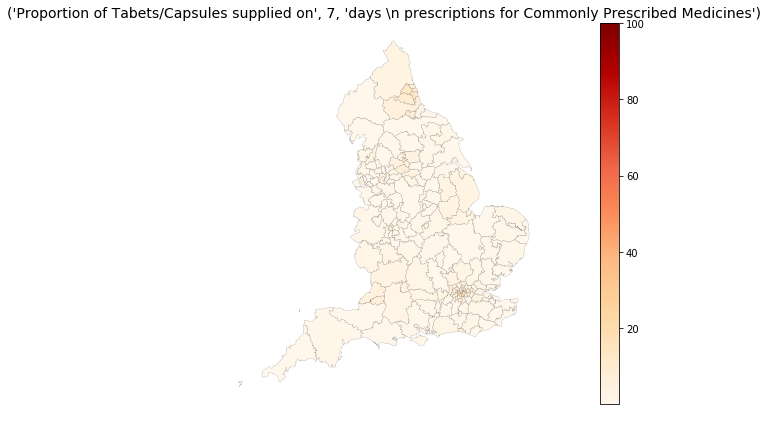

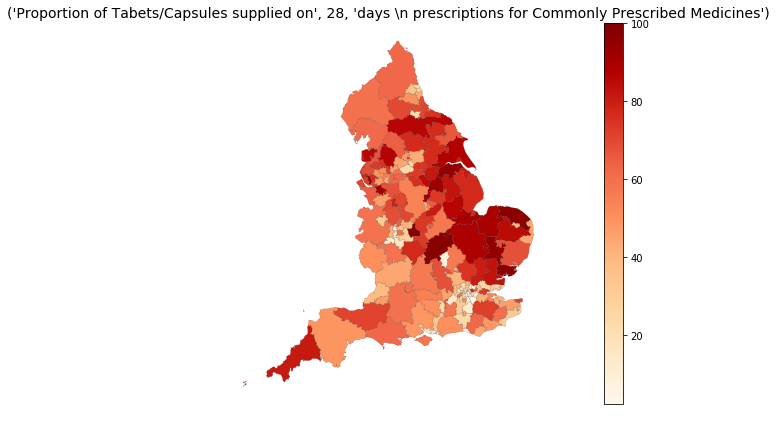

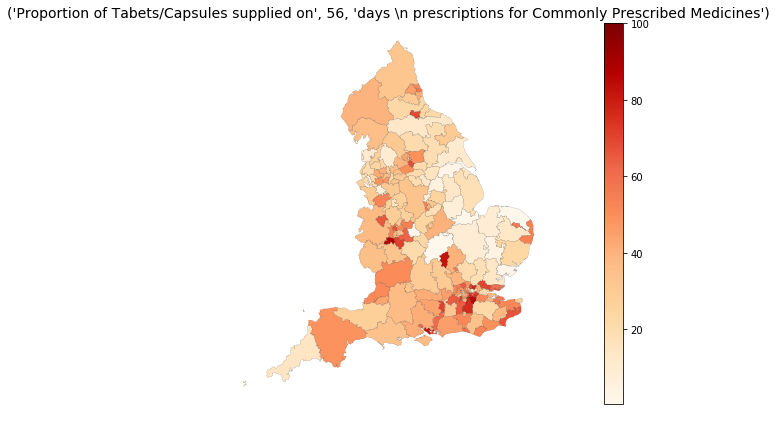

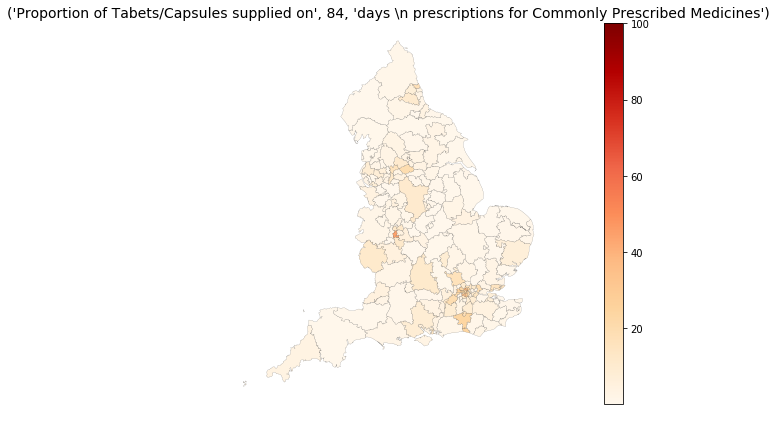

In [16]:
for quantity_per_item in ccg_map.quantity_per_item.unique():
    plt.figure(figsize=(20, 7))
    maps.ccg_map(
        ccg_map[ccg_map['quantity_per_item'] == quantity_per_item], 
        title= ("Proportion of Tabets/Capsules supplied on", quantity_per_item, "days \n prescriptions for Commonly Prescribed Medicines"),
        column='proportion_of_basket', 
        separate_london=False,
        plot_options={'vmax': 100}
    )
    plt.show()

My impression is that the 28 day supply map looks similar to SystmOne v EMIS Web [map of deployment](https://github.com/ebmdatalab/jupyter-notebooks/blob/master/General%20Practice%20EHR%20Deployment/EHR%20Deployment.ipynb)

## Excessive quantities in CCGs

Above we saw that there are some excessive quantities being prescribed, one script for 8400 would equate to 23 years supply and it was prescribed in a single month. It is unlikely that it was dispensed but we will now interrogate the data to see what the true cost of excessive prescribing is. We cannot investigate further so we will create files for interested CCGs - perhaps we could do mass audit?

In [18]:
### here we extract data for modelling
sql = '''
SELECT
  month,
  pct,
  practice,
  bnf_name,
  items,
  actual_cost,
  quantity_per_item
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
  hscic.ccgs AS ccgs
ON
presc.pct=ccgs.code
WHERE
(bnf_code LIKE "0205051R0%" OR  ##ramipril
bnf_code LIKE "0212000B0%" OR ##atrovastatin
bnf_code LIKE "0212000Y0%" OR ##simvastatin
bnf_code LIKE "0602010V0%" OR ##levothyroxine
bnf_code LIKE "0206020A0%") ##amlodipine
AND
(bnf_name LIKE '%_Tab%' or bnf_name LIKE '%_Cap%') ##this restricts to tablets or capsules
AND (month >= '2018-08-01'
    AND month <= '2019-07-01')
AND
quantity_per_item >= 336 ##this is one years supply

AND
ccgs.org_type='CCG'
GROUP BY
  month,
  pct,
  practice,
  bnf_name,
  items,
  actual_cost,
  quantity_per_item
    '''

df_excess = bq.cached_read(sql, csv_path='..\data\ltc_qty_excess.csv')
df_excess.head(10)

,month,pct,practice,bnf_name,items,actual_cost,quantity_per_item
0,2019-04-01,00M,A81023,Levothyrox Sod_Tab 25mcg,1,22.72856,420
1,2019-04-01,01G,P87620,Levothyrox Sod_Tab 50mcg,1,11.49591,336
2,2019-04-01,01Y,C81106,Levothyrox Sod_Tab 100mcg,1,11.49591,336
3,2019-04-01,01Y,P89030,Levothyrox Sod_Tab 25mcg,1,18.18533,336
4,2019-04-01,02M,P81149,Levothyrox Sod_Tab 25mcg,1,21.75082,400
5,2019-04-01,00L,A84011,Levothyrox Sod_Tab 100mcg,1,13.66686,400
6,2019-04-01,13T,A85020,Levothyrox Sod_Tab 100mcg,1,11.49591,336
7,2019-04-01,03H,B81030,Levothyrox Sod_Tab 50mcg,1,12.45286,364
8,2019-04-01,03H,B81091,Levothyrox Sod_Tab 50mcg,1,17.19830,500
9,2019-04-01,03K,B81007,Levothyrox Sod_Tab 100mcg,1,26.80725,784


In [19]:
df_excess.describe()

,items,actual_cost,quantity_per_item
count,2276.000000,2276.000000,2276.000000
mean,1.074692,21.833317,422.605009
std,0.424162,54.689319,298.873079
min,1.000000,6.253670,336.000000
25%,1.000000,11.948050,336.000000
50%,1.000000,17.292860,336.000000
75%,1.000000,22.649910,420.000000
max,8.000000,2409.878090,8400.000000


In [20]:
df_excess.sum()

items                  2446.00000
actual_cost           49692.62845
quantity_per_item    961849.00000
dtype: float64

In [ ]:
# here we create csv files for each CCG to investigate further if they wish - these are now available on GitHub
for i, g in df_excess.groupby('pct'):
     g.to_csv('..\data\{}.csv'.format(i.split('/')[0]), index=False)


 code review improvements - what I would like to tweak
- Cartogram Map titles, they do not look right but it fails when I try tweaking. How do you combine the changing column title and a nonchangeable string
- csv files for each ccg. I'd like to put them in a seperate folder.
- currently has 12 months to July 19, we should update with latest if going anywhere.